In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
url_list = make_urllist(2, 105, 20231010)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [3]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '104' : '세계', '105' : 'IT/과학'}

In [4]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [5]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [6]:
data = make_data(url_list, 105)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,"[국감2023] “일단 뒤져봐?” 방통위 네이버 현장조사, 야당서 질타 쏟아져",IT/과학
1,"""알뜰폰 8년간 유해정보 차단 점검 X""…방통위 ""점검 확대하겠다""",IT/과학
2,'감원 우려 제기' 학생연구원 규모 유지… 출연연 쌈짓돈 활용,IT/과학
3,"野 ""법적권한 없다"" 與 ""적극 대응해야""...가짜뉴스 공방 쳇바퀴",IT/과학
4,[국감2023] 과방위 단골키워드 ‘구글 갑질’…이동관은 막을 수 있을까?,IT/과학
5,"하이브IM, 신작 '별이되어라2' 글로벌 테스트 시작",IT/과학
6,"삼성 ‘무타공 솔루션’, 벽 훼손 없이 TV 설치",IT/과학
7,"LG家 상속분쟁 세 모녀 변호인, 첫 변론 직후 사임",IT/과학
8,"말로는 ‘디지털 격차 해소’, 실제론 ‘정부 예산 반토막’",IT/과학
9,1급 발암물질인데…라돈침대 폐기물 5년 넘게 방치,IT/과학


In [7]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [8]:
df = make_total_data(2, code_list, 20231019)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [9]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data.csv File Saved!


In [10]:
df2 = make_total_data(2, code_list, 20231130)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [11]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data12.csv"
df2.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data12.csv File Saved!


# 데이터 정제

In [12]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,[게시판] 캐나다 몬트리올서 韓·퀘벡 비즈니스 네트워킹 행사,사회
1,"전세사기 사각지대 '근생빌라', 3년간 4300여 채 적발…이행강제금 200억 원",사회
2,‘의생역전’에 12년 올인…월 400만원 의대준비반 6분만에 마감,사회
3,[이·팔 전쟁] 바이든 '인질석방 최우선'방침에도 美서 '최악 시나리오'도 거론,사회
4,"""영양제인 것처럼""...온라인 부당광고 3백 건 적발",사회


In [13]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_256/1017750076.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0              게시판 캐나다 몬트리올서 퀘벡 비즈니스 네트워킹 행사
1          전세사기 사각지대 근생빌라 년간 여 채 적발이행강제금 억 원
2                의생역전에 년 올인월 만원 의대준비반 분만에 마감
3       이팔 전쟁 바이든 인질석방 최우선방침에도 서 최악 시나리오도 거론
4                    영양제인 것처럼온라인 부당광고 백 건 적발
                       ...                  
115                 삼성전자 년 나노  개발전장 파운드리 자신감
116             삼성전자 년까지 나노 램 개발한다전장 로드맵 구체화
117      아 이럴수가 이수만 제치려다 사달카카오 경영진 구속 초유의 사태
118            가렌 또 꺼낸  아담는 안티 캐리 최강자 롤드컵 줌인
119     아담 가다세올로 더 멋진 모습 보여줄 것좋아하는 챔피언 뽑아도 돼
Name: news, Length: 120, dtype: object

In [14]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [15]:
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  113


<AxesSubplot:>

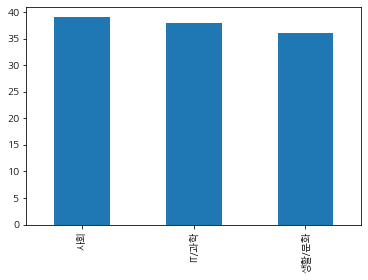

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [17]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     38
1     사회     39
2  생활/문화     36


In [18]:
from konlpy.tag import Hannanum
tokenizer = Hannanum()
kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속됐다서울', '제주경찰', '서는', '상하', '어', '혐의', '로', '씨', '를', '구속해', '수사', '하고', '있', '다', '고', '일', '밝혔다씨', '는', '지난달', '일', '피하', '어', '여성', '을', '인근', '지하철', '역', '에서부터', '따르', '아', '가', '아', '폭행', '을', '시도', '하', '려', '다가', '도망가', 'ㄴ', '혐의', '를', '받는다피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '아며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포됐다피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었다']


In [19]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','으로','의','만']

In [20]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [21]:
text_data = preprocessing(df['news'])
print(text_data[0])

게시판 크 어 나 아 몬트리올서 퀘벡 비즈니스 네트워킹 행사


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [23]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [24]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 84
테스트용 뉴스 기사의 개수 :  29
훈련용 레이블의 개수 :  84
테스트용 레이블의 개수 :  29


In [25]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [26]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [27]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [28]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [29]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [30]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.80      0.36      0.50        11
          사회       0.71      0.45      0.56        11
       생활/문화       0.41      1.00      0.58         7

    accuracy                           0.55        29
   macro avg       0.64      0.61      0.55        29
weighted avg       0.67      0.55      0.54        29



# 데이터 합치기

In [59]:
import pandas as pd

combined_data = pd.concat([df, df2], ignore_index=True)

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/combined_data2.csv"
combined_data.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/combined_data2.csv File Saved!


In [60]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/combined_data2.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,게시판 캐나다 몬트리올서 퀘벡 비즈니스 네트워킹 행사,사회
1,전세사기 사각지대 근생빌라 년간 여 채 적발이행강제금 억 원,사회
2,의생역전에 년 올인월 만원 의대준비반 분만에 마감,사회
3,이팔 전쟁 바이든 인질석방 최우선방침에도 서 최악 시나리오도 거론,사회
4,영양제인 것처럼온라인 부당광고 백 건 적발,사회


In [61]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_256/1017750076.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0             게시판 캐나다 몬트리올서 퀘벡 비즈니스 네트워킹 행사
1         전세사기 사각지대 근생빌라 년간 여 채 적발이행강제금 억 원
2               의생역전에 년 올인월 만원 의대준비반 분만에 마감
3      이팔 전쟁 바이든 인질석방 최우선방침에도 서 최악 시나리오도 거론
4                   영양제인 것처럼온라인 부당광고 백 건 적발
                       ...                 
336       콜 몰아주기 없앤다카카오모빌리티 최단거리 우선 배차 도입종합
337    김성진 한국앤컴퍼니 전무 타이어도 모빌리티 필수요소생성형로  가속
338                  민트로켓 신작 낙원 게이머와 미리 만난다
339              지역정보개발원 디지털 지역혁신 글로벌 포럼 개최
340          넷마블이 만든 버추얼 아이돌 그룹 메이브 일 신곡 발매
Name: news, Length: 341, dtype: object

In [62]:
print(df.isnull().sum())

news    2
code    0
dtype: int64


In [63]:
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  221


In [64]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     75
1     사회     75
2  생활/문화     71


In [65]:
from konlpy.tag import Okt
tokenizer = Okt()
kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐다', '서울', '제', '주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하고', '있다고', '일', '밝혔다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하려다가', '도망간', '혐의', '를', '받는다', '피해', '여성', '이', '저항', '하자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받고', '주변', '을', '수색', '하던', '경찰', '에', '체포', '됐다', '피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입은', '것', '으로', '전해졌다']


In [66]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하',
             '한','다','과','때문','할','수','무단','따른','및','금지',
             '전재','경향신문','기자','는데','가','등','들','파이낸셜','저작',
             '등','뉴스','으로','의','만', '를', '하던', '했다', '것',
            '하자', '됐다', '부터', '로써', '께', '로서', '와', '조차']

In [67]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [77]:
text_data = preprocessing(df['news'])
print(text_data[0])

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [76]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [69]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 84
테스트용 뉴스 기사의 개수 :  29
훈련용 레이블의 개수 :  84
테스트용 레이블의 개수 :  29


In [70]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [71]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [72]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [73]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [74]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [75]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.80      0.36      0.50        11
          사회       0.71      0.45      0.56        11
       생활/문화       0.41      1.00      0.58         7

    accuracy                           0.55        29
   macro avg       0.64      0.61      0.55        29
weighted avg       0.67      0.55      0.54        29



In [ ]:
#회고 : 데이터의 수가 증가 할 수록 더 정확도가 높은것을 확인하였으나 500문제로 인하여 크롤링이 더 이상 안되는 문제를 해결하지 못하여서 아쉬웠다.